#Clock recognition train

Model based on [Colab Notebook](https://colab.research.google.com/drive/1_-zy0nGWoSBUmJOD-x2_T2KTzGlqvikk?usp=sharing#scrollTo=n8InHz5NBFrV).
This model based on a Google model which powered the site [Quick, Draw!](https://quickdraw.withgoogle.com//).

The model modified to our needs to predict a clock rank in range 0 - 1.

In [ ]:
!wget 'https://raw.githubusercontent.com/AvrahamBi/Cogni-ml-config/master/mini_classes.txt'

--2022-05-23 12:03:07--  https://raw.githubusercontent.com/AvrahamBi/Cogni-ml-config/master/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 673 [text/plain]
Saving to: ‘mini_classes.txt.1’

mini_classes.txt.1  100%[===================>]     673  --.-KB/s    in 0s      

2022-05-23 12:03:07 (34.2 MB/s) - ‘mini_classes.txt.1’ saved [673/673]



In [ ]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [ ]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [ ]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train))

284800


rainbow


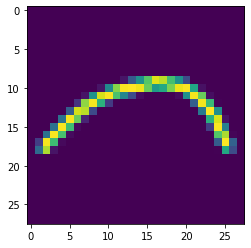

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [ ]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(89, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [ ]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 201s - loss: 1.9251 - top_k_categorical_accuracy: 0.7808 - val_loss: 1.3938 - val_top_k_categorical_accuracy: 0.8745 - 201s/epoch - 179ms/step
Epoch 2/5
1125/1125 - 203s - loss: 1.2466 - top_k_categorical_accuracy: 0.8921 - val_loss: 1.1554 - val_top_k_categorical_accuracy: 0.9030 - 203s/epoch - 180ms/step
Epoch 3/5
1125/1125 - 208s - loss: 1.0835 - top_k_categorical_accuracy: 0.9102 - val_loss: 1.0674 - val_top_k_categorical_accuracy: 0.9122 - 208s/epoch - 184ms/step
Epoch 4/5
1125/1125 - 201s - loss: 0.9948 - top_k_categorical_accuracy: 0.9195 - val_loss: 0.9914 - val_top_k_categorical_accuracy: 0.9197 - 201s/epoch - 178ms/step
Epoch 5/5
1125/1125 - 200s - loss: 0.9337 - top_k_categorical_accuracy: 0.9255 - val_loss: 0.9802 - val_top_k_categorical_accuracy: 0.9207 - 200s/epoch - 177ms/step


# Test

In [ ]:
from PIL import Image
import io
import base64

In [ ]:
def predict(img_mongo):
  img64 = img_mongo[22:]
  img_decode = Image.open(io.BytesIO(base64.decodebytes(bytes(img64, "utf-8"))))
  resize_img = img_decode.resize(size=(28, 28))
  # resize_img = resize_img.convert('RGB') # 1 dimension
  # resize_img = resize_img.convert('LA') # 1 dimension
  # resize_img = np.expand_dims(resize_img, axis=-1)
  img_numpy = np.array(resize_img) 
  if len(img_numpy.shape) > 2 and img_numpy.shape[2] == 4:
    #slice off the alpha channel
    img_numpy = img_numpy[:, :, 1]
  img_numpy = (255.0 - img_numpy) / 255.0
  img_numpy = np.where(img_numpy>0.1,0.75,img_numpy) # here
  img_numpy = np.where(img_numpy>0,img_numpy+0.20,0)
  plt.imshow(img_numpy.squeeze())
  pred = model.predict(np.expand_dims(img_numpy, axis=0))[0]
  ind = (-pred).argsort()[:5]
  latex = [class_names[x] for x in ind]
  print(latex)
  print ([pred[x] for x in ind])

  clock_ind = class_names.index("clock")
  print("is clock " , pred[clock_ind])
  print("")
  return pred[clock_ind]

# MongoDb controller

In [ ]:
!pip install dnspython
!pip3 uninstall pymongo
!pip3 install pymongo[srv]

In [ ]:

import string
import random
import pymongo
import operator
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [ ]:
# consts
USER = "admin"
PASS = "admin"
CONNECTION_STRING = "mongodb+srv://" + USER + ":" + PASS + "@cluster0.0anzo.mongodb.net/Cogni" #?retryWrites=true&w=majority"
FIELDS = ["_id", "gender", "age", "sketchTime", "startTime", "count_path", "count_reset", "count_undo"] # TBD: path, label should be generated.
TARGET_INDEX = 8
GENERATE_TESTS = 10

In [ ]:
# generate random test
def generate_test():
    _id = ''.join(random.choice(string.ascii_letters) for i in range(8))
    gender = random.randint(0, 1)
    age = random.randint(8, 90)
    sketchTime = random.randint(100, 100000)
    startTime = random.randint(100, 100000)
    count_path = random.randint(4, 24)
    count_reset = random.randint(0, 3)
    count_undo = random.randint(0, 6)
    label = random.randint(1, 5)
    pred = float(random.random())
    return {'_id' : _id, 'gender' : gender, 'age' : age, 'sketchTime' : sketchTime, 'startTime' : startTime,
            'count_path' : count_path, 'count_reset' : count_reset, 'count_undo' : count_undo, 'label' : label, 'pred' : pred}


In [ ]:
# get tests features from MongoDb
def get_tests(client):
    tests = client.tests.clock.find()
    tests_arr = []
    for test in tests:
        dict = {}
        for field in FIELDS:
            if (field == "_id"):
                dict[field] = str(test[field])
                continue
            dict[field] = test[field]
        dict["label"] = random.randint(1, 5)
        # add prediction
        dict["pred"] = float(predict(test["img_base64"]))
        tests_arr.append(dict)
    if (0 < GENERATE_TESTS):
        for i in range(GENERATE_TESTS):
            tests_arr.append(generate_test())
    print("Tests loaded from MongoDb and", GENERATE_TESTS, "tests have been generated.")
    return tests_arr

In [ ]:
# clear dataset database
def clear_dataset(client):
    dataset = client.ml.dataset
    for test in dataset.find():
        dataset.delete_one(test)
    print("MongoDb dataset has been deleted!")

In [ ]:
# load data to dataset
def load_data(client, tests):
    dataset = client.ml.dataset
    for test in tests:
        dataset.insert_one(test)
    print("Dataset has been uplpaded to MongoDb.")

In [ ]:
def get_dataset(client, target_index):
    db = client.ml.dataset.find()
    matrix = []
    i = 0
    for test in db:
        arr = []
        for feature in test:
            arr.append(test[feature])
        i += 1
        matrix.append(arr)
    matrix = np.array(matrix)
    y = matrix[:,target_index]
    # remove _id column
    x = np.delete(matrix, obj=0, axis=1)
    # remove target column from x
    x = np.delete(matrix, obj=8, axis=1)
    #
    oe = OrdinalEncoder()
    oe.fit(x)
    x = oe.transform(x)
    # encode y
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    return x , y

In [ ]:
def get_scores(client, target_index):
    x, y = get_dataset(client, target_index)
    selector = SelectKBest(score_func=chi2, k='all')
    selector.fit(x, y)
    scores_dict = {}
    for i, field in zip(range(len(selector.scores_)), FIELDS[1:]):
        scores_dict[field] = round(selector.scores_[i], 2)
    sorted_scores_dict = {k: v for k, v in sorted(scores_dict.items(), reverse=True, key=lambda item: item[1])}
    return scores_dict, sorted_scores_dict

In [ ]:
def print_scores(sorted_scores_dict):
    print("")
    print("List of features and scores.")
    print("higher score means higher correlation between feature to target.")
    for key in sorted_scores_dict:
        #print(key,'\t', sorted_scores_dict[key])
        line = '%14s %14s' % (key, sorted_scores_dict[key])
        print(line)

In [ ]:
# show graph of features and scores to user
def show_graph(dict):
    # plot the scores
    keys = []
    scores = []
    for key in dict:
        keys.append(key)
        scores.append(dict[key])
    plt.bar(keys, scores)
    plt.title("Higher means stronger correlation.")
    plt.xticks(rotation=270)
    plt.show()

# main

In [ ]:
if __name__ == "__main__":
    # connect to MongoDb client
    client = MongoClient(CONNECTION_STRING)


In [ ]:
    # clear MongoDb dataset
    clear_dataset(client)

MongoDb dataset has been deleted!


['sun', 'line', 'diving_board', 'lightning', 'light_bulb']
[0.26075575, 0.1473727, 0.11392926, 0.06866295, 0.04450149]
is clock  7.308571e-05

['lightning', 'diving_board', 'line', 'bread', 'mushroom']
[0.44190893, 0.07321774, 0.053915396, 0.047209043, 0.041415554]
is clock  0.0014626632

['lightning', 'syringe', 'line', 'diving_board', 'mushroom']
[0.6663401, 0.055916242, 0.052867826, 0.019320304, 0.019073272]
is clock  0.00040857669

['line', 'lightning', 'screwdriver', 'power_outlet', 'diving_board']
[0.19748418, 0.17584157, 0.056762744, 0.04099744, 0.039873753]
is clock  0.0018919774

['sun', 'cloud', 'bird', 'light_bulb', 'lightning']
[0.4196708, 0.14837019, 0.09708765, 0.066971265, 0.032884445]
is clock  0.00023162554

['spoon', 'baseball_bat', 'axe', 'lightning', 'ice_cream']
[0.37155843, 0.15802917, 0.061707117, 0.04871341, 0.04808594]
is clock  0.00025967063

['line', 'moustache', 'diving_board', 'axe', 'cloud']
[0.26079333, 0.15054703, 0.119025655, 0.08691749, 0.02883787]
is 

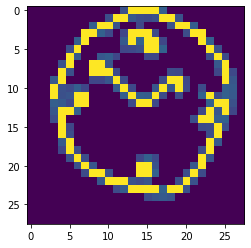

In [ ]:
    # get tests from MongoDb, and create dataset
    data = get_tests(client)   # tests = [{}, {}, {}]

In [ ]:
    # upload dataset into MongoDb
    load_data(client, data)

Dataset has been uplpaded to MongoDb.


In [ ]:
    # calculate scores of features
    scores_dict, sorted_scores_dict = get_scores(client, TARGET_INDEX)


List of features and scores.
higher score means higher correlation between feature to target.
    sketchTime          52.95
   count_reset          36.69
    count_path          23.45
     startTime          23.27
    count_undo          17.97
        gender          13.54
           age           0.94


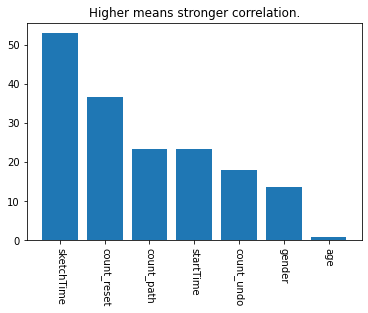

In [ ]:
    # show scores of features
    print_scores(sorted_scores_dict)
    show_graph(sorted_scores_dict)
